In [ ]:
# working to do the zombies networks model

In [1]:
%matplotlib inline

import numpy as np
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import pause
import networkx as nx
import matplotlib as mt
import graphviz
from networkx import graphviz_layout
import pydot
import pylab

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# in case you want to name your people
#http = urllib3.PoolManager()
#names = http.request('GET', 'http://deron.meranda.us/data/census-derived-all-first.txt')

# want to start assigning ppl value so fighting may actually be worth it
# ie, if you fight, you can split the value of the ppl you kill
# if you join, they keep their shit

# should make babies not useful -- needs to take some number of rounds for them to grow up

# should make human/zombie strength an input

# want to animate the graph so you can see what happens at each step

# for some reason the crews are not actually disjoint

In [93]:
def start( n, pr ):
    # clears graph and starts a new one
    # n people, with pr probability of getting infected at stage 1
    # needs error handling for probability between 0 and 1, though this will get caught by python
    
    global G; global c; global zom; global hum
    
    hum = []; zom = []; c = []
    
    try:G.clear()
    except: print("no error: nothing to clear")

    # generate your starting graph
    G=nx.Graph()
    
    k = 1
    while k <= n:
        #randomly make a node human or zombie
        G.add_node(k, state = np.random.choice(['zombie','human'], p=[pr,1-pr])) 

        # if it's human, collect it, color it blue and connect it to humans
        if G.node[k]['state']=='human':
            hum.append(k)
            c.append('blue')
            G.add_edge(k, np.random.choice(hum))

        # if it's a zombie, collect it, color it red and connect it to zombies    
        else:
            zom.append(k)
            c.append('red')
            G.add_edge(k, np.random.choice(zom))
        k +=1

In [62]:
def pick_person( hum ):
    global me
    while True:
        me = int(input("pick a person from %s "%(hum)))
        if me in zom: print("pick an actual person")
        else: break

In [158]:
def begin_round( n, me ):
    global game; global e2; global crew2; global zs; global crew1; global hs
    e2 = np.random.choice(G.nodes())
    for i in list(nx.connected_components(G)):
        if me in i: crew1 = i; hs = len(i)
    for i in list(nx.connected_components(G)):
        if e2 in i: crew2 = i; zs = len(i)
    if crew2 == crew1: game = 0 # you're just hanging out w your crew
    elif G.node[e2]['state'] == 'human': game = 1 # human to human encounter
    else: game = 2 # zombie to zombie encounter

In [200]:
def human_fight( k, hs, zs, crew1, crew2, e2, me ):
    global G
    dec = input("fight, flee or join?")
        
    if dec == "fight":
        print("round %d. you said fight, so we're fighting. its the %d of you against %d"%(k, hs, zs))
        for nd in crew1:
            #your ppl can die
            if  .5*hs - .5*zs + np.random.normal() < -0.7:
                print("round %d. your buddy human %d is dead"%(k, nd))
                G.node[nd]["state"] = 'dead' # person nd is dead
            else: G.add_edge(nd,e2) #whoever doesn't die, joins

        for nd in crew2:
            # their people can die
            if  .5*hs - .5*zs + np.random.normal() > 0.7:
                print("round %d. that loser human %d is dead"%(k, nd))
                G.node[nd]["state"] = 'dead' # person is dead
            else: G.add_edge(nd,me)

    elif dec == "join": 
        print("round %d. yea! further the human project!"%(k))
        if np.random.rand() > .8:
            b = max(G.nodes())+1
            G.add_node(b, state = 'human')
            G.add_edge(b,me)
            G.add_edge(b,e2)
            print("round %d. love wins, baby %d born"%(k, b))
            G.add_edge(me,e2)
        else:
            G.add_edge(me,e2)
            
    else: print("round %d. successful fleeing"%(k))

In [65]:
def zombie_fight(k,zs,hs,crew1,crew2,e2):
    global G
    print("round %d. %d zombies attacking %d humans"%(k, zs, hs))

    # see what happens to the humans: roll a die for each person in human group
    for nd in crew1:
        if  .01 - 0.7*hs + .05*zs + np.random.normal() > 0:
            print("round %d. human %d infected"%(k, nd))
            G.node[nd]['state'] = 'zombie' # person is a zombie
            G.remove_edges_from(G.edges(nd)) # person disconnected from all humans
            G.add_edge(nd,e2) # person joins zombie herd
        elif -.8*hs + .02*zs + np.random.rand() > 0:
            print("round %d. human %d dead"%(k, nd))
            G.node[nd]["state"] = 'dead' # person is dead

    # see what happens to the zombies
    
    for nd in crew2:
        if .5 - 0.1*zs + .1*hs + np.random.normal() > 1:
            print("round %d. zombie %d killed"%(k, nd))
            G.node[nd]["state"] = 'dead' # zombie is dead

In [66]:
def clean_up():
    global G; global c
    c = []
    for i in G.nodes():
        try: 
            if G.node[i]['state'] == 'dead': G.remove_node(i)
            elif G.node[i]['state'] == 'human': c.append('blue')
            elif G.node[i]['state'] == 'zombie':c.append('red')
        except:
            G.remove_node(i)

In [67]:
def get_fig(G,c):
    # would lik to figure out how to animate this as you go
    nx.draw(G, node_color = c, with_labels = True, node_size = 500)

In [68]:
def apocalypse( rounds, n, pr ):
    start( n, pr )
    pick_person( hum )
    global k
    k = 1
    while k <= rounds:
        begin_round( n, me )
        if game == 1: human_fight(  k, hs, zs, crew1, crew2, e2, me )
        elif game == 2: zombie_fight( k,zs,hs,crew1,crew2,e2 )
        else: print("nothing doing")
        clean_up()
        k +=1
    get_fig(G,c)

pick a person from [6, 8, 9, 10, 11, 16] 6
round 1. 3 zombies attacking 3 humans
round 1. zombie 12 killed
round 2. 1 zombies attacking 3 humans
round 2. zombie 14 killed
fight, flee or join?join
round 3. yea! further the human project!
round 3. love wins, baby 21 born
round 4. 2 zombies attacking 7 humans


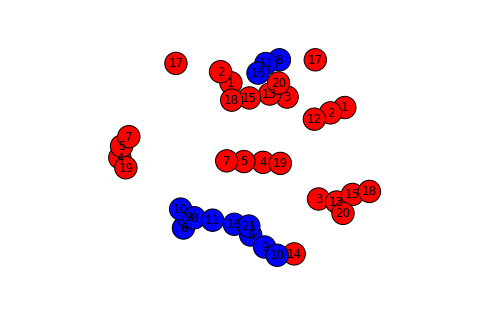

In [84]:
apocalypse(4, 20, .8)

In [ ]:
#Can run step by step here:

In [201]:
start(40,.7)

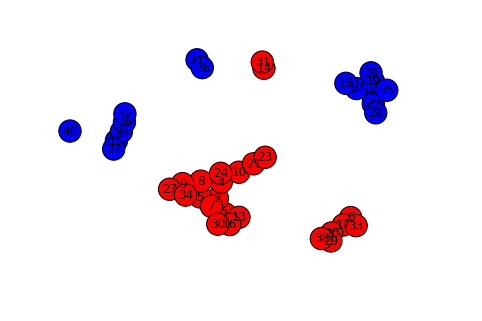

In [202]:
nx.draw(G, node_color = c, with_labels = True, node_size = 500)

In [203]:
pick_person(hum)

pick a person from [3, 11, 12, 15, 18, 19, 22, 25, 26, 28, 32, 35, 36, 37, 39, 40] 3


In [220]:
begin_round(1,me)
game

1

In [221]:
crew2

{11, 36}

In [192]:
#if game is 2, do a zombie fight
zombie_fight(k,zs,hs,crew1,crew2,e2)

round 5. 7 zombies attacking 5 humans


In [222]:
#if game is 1, do a human fight
human_fight(  k, hs, zs, crew1, crew2, e2, me )

fight, flee or join?fight
round 5. you said fight, so we're fighting. its the 13 of you against 2
round 5. that loser human 11 is dead
round 5. that loser human 36 is dead


In [223]:
clean_up()

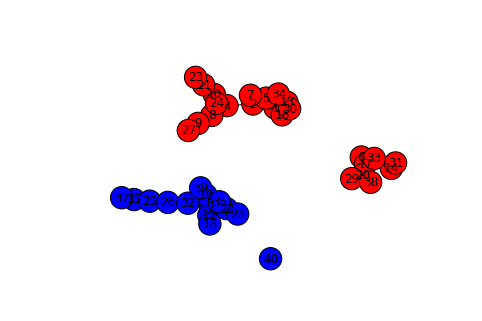

In [224]:
nx.draw(G, node_color = c, with_labels = True, node_size = 500)